In [1]:
import sys
utils_path = '/global/homes/f/fnafis/nfkrstc/'
if utils_path not in sys.path:
    sys.path.append(utils_path)
import krstc_utils as kutils

import pygama.lgdo.lh5_store as lh5
from pygama.flow import DataGroup
import pygama.math.histogram as pgh
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('/global/homes/f/fnafis/utils_nf/nfuad.mpl')
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import h5py


runs = [76, 71, 66, 80] #86 is temp test, only keep 3734-3738(inclusive)
bias_voltages = [2200, 2300, 2400, 2500]

skip_cycless = [[],
               [3298,3299,3300,3301],
               [],
               []]
bkg_run = 85 #72
bkg_skip_cycles = None #np.arange(3315,3340)
    

# cutoff in ToE plots of C10 2400V Kr runs

In [10]:
df, runtype = kutils.load_dsp(83, params=[['trapEmax', 'triE', 'tp_0', 'stp_20', 'tp_20', 'tp_50']], verbose=False)
df['ToE'] = df['triE']/df['trapEmax']
df

,trapEmax,triE,tp_0,stp_20,tp_20,tp_50,trapEmax_cal_keV,pulse_rise_time_ns,run,cycle,runtime_s,ToE
0,191.629562,94.553970,39710.0,39810.0,39820.0,39890.0,82.724342,100.0,83,3461,1498.422083,0.493421
1,37.535671,27.208134,39260.0,39260.0,39280.0,39350.0,16.309874,0.0,83,3461,1498.422083,0.724861
2,1781.767700,1047.411621,39680.0,40200.0,40210.0,40320.0,768.073914,520.0,83,3461,1498.422083,0.587850
3,1990.586914,1169.642944,39400.0,40280.0,40300.0,40410.0,858.074951,880.0,83,3461,1498.422083,0.587587
4,13.853807,13.301734,38140.0,38120.0,38330.0,39410.0,6.102991,-20.0,83,3461,1498.422083,0.960150
...,...,...,...,...,...,...,...,...,...,...,...,...
115389,385.457825,230.125320,39180.0,39980.0,39990.0,40100.0,166.264328,800.0,83,3578,1499.753282,0.597018
115390,1444.228516,813.459473,39520.0,40030.0,40040.0,40130.0,622.594482,510.0,83,3578,1499.753282,0.563248
115391,342.836487,185.610764,39470.0,39920.0,39930.0,40050.0,147.894531,450.0,83,3578,1499.753282,0.541397
115392,2548.177002,1501.033447,39760.0,40320.0,40340.0,40450.0,1098.396240,560.0,83,3578,1499.753282,0.589062


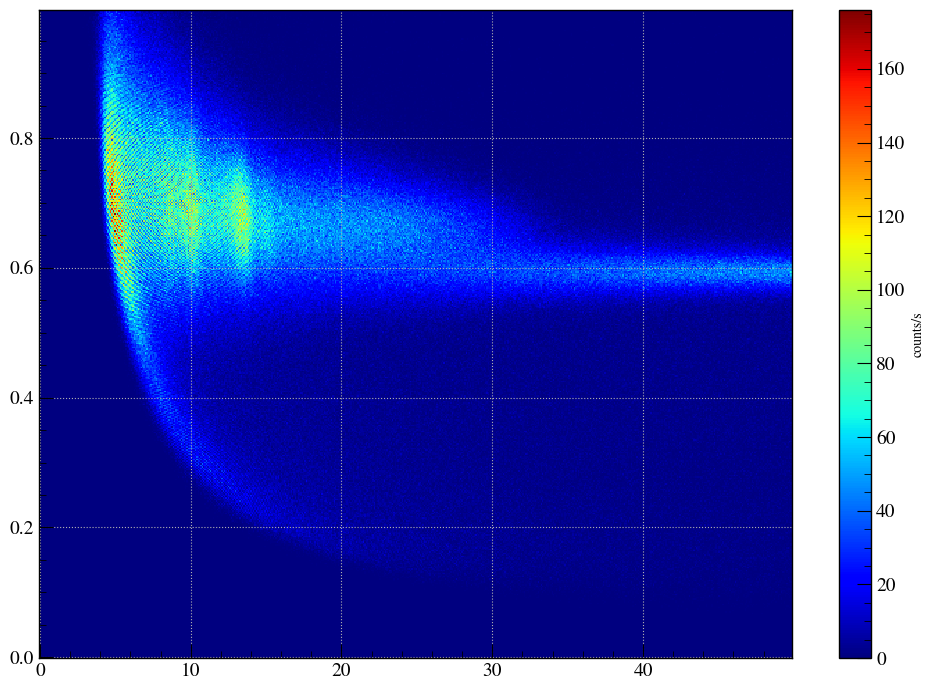

In [11]:
toe = kutils.get_2D_hist(df['trapEmax_cal_keV'], df['ToE'], df['runtime_s'], ranges=[[0,50],[0,1]])

In [5]:
df_bkg, bkg_runtype = kutils.load_dsp(run=bkg_run, params=[['trapEmax', 'triE']], all_columns=False, verbose = False, skip_cycles=bkg_skip_cycles)
# del df_bkg['trapEmax']
#del df['tp_0']
# del df['stp_20']
df_bkg['ToE'] = df_bkg['triE'] / df_bkg['trapEmax']
print(df_bkg.cycle.unique())
df_bkg

[3610 3611 3612 ... 3721 3722 3723]


,trapEmax,triE,trapEmax_cal_keV,run,cycle,runtime_s,ToE
0,490.429871,291.863434,211.507278,85,3610,1498.848120,0.595118
1,2969.739990,1745.162109,1280.089844,85,3610,1498.848120,0.587648
2,843.179993,502.285858,363.542572,85,3610,1498.848120,0.595704
3,536.413940,304.171478,231.326416,85,3610,1498.848120,0.567046
4,416.795319,248.841049,179.770782,85,3610,1498.848120,0.597034
...,...,...,...,...,...,...,...
20322,1543.015381,854.206909,665.171631,85,3723,294.288145,0.553596
20323,606.854248,359.500183,261.686157,85,3723,294.288145,0.592400
20324,194.907959,76.947960,84.137337,85,3723,294.288145,0.394791
20325,687.529846,432.714111,296.457336,85,3723,294.288145,0.629375


# energy spectra with a ToE cut

[3363 3364 3365 ... 3374 3375 3376]
[3294 3295 3296 ... 3312 3313 3314]
[3230 3231 3232 ... 3247 3248 3249]
[3413 3414 3415 ... 3451 3452 3453]


Text(0, 0.5, 'counts/s/keV')

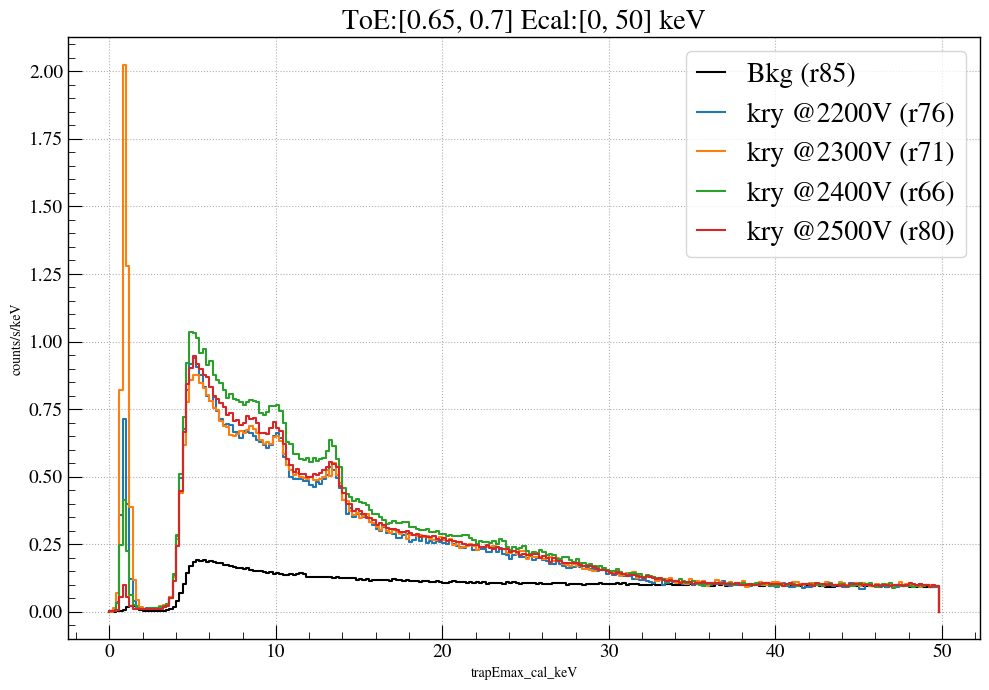

In [4]:
toe_range = [0.65,0.7]
ecal_range = [0, 50]
binsize = 0.2 #keV

toe_cut = (df_bkg['ToE'] > toe_range[0]) & (df_bkg['ToE'] < toe_range[1])
ecal_cut = (df_bkg['trapEmax_cal_keV'] > ecal_range[0]) & (df_bkg['trapEmax_cal_keV'] < ecal_range[1])

cut = ecal_cut

bkg_spectrum = kutils.get_1D_hist(df_bkg[cut]['trapEmax_cal_keV'], df_bkg[cut]['runtime_s'], range=ecal_range, binsize=binsize, lw=1.5, color='k', label='Bkg (r'+str(bkg_run)+')')


for i in range(len(runs)):
    df, runtype = kutils.load_dsp(run=runs[i], params=[['trapEmax', 'triE']], all_columns=False, verbose = False, skip_cycles=skip_cycless[i])
    df['ToE'] = df['triE'] / df['trapEmax']
    print(df.cycle.unique())

    toe_cut = (df['ToE'] > toe_range[0]) & (df['ToE'] < toe_range[1])
    ecal_cut = (df['trapEmax_cal_keV'] > ecal_range[0]) & (df['trapEmax_cal_keV'] < ecal_range[1])
    cut = toe_cut & ecal_cut

    spectrum = kutils.get_1D_hist(df[cut]['trapEmax_cal_keV'], df[cut]['runtime_s'], range=ecal_range, binsize=binsize, lw=1.5, label=runtype+' @'+str(bias_voltages[i])+'V (r'+str(runs[i])+')')

plt.title('ToE:'+str(toe_range)+' Ecal:'+str(ecal_range)+' keV')
plt.xlabel('trapEmax_cal_keV')
plt.ylabel('counts/s/keV')

# Kr buildup visualization

66--kry--8.02913383456389 hrs--2023/04/24 bias at 2400, closed turbo valve, krypton run


,runtime,counts
0,1498.680678,2836
1,1498.686414,3174
2,1498.974917,3759
3,1499.800067,4448
4,1499.027622,5136
5,1499.475777,5944
6,1499.859605,7104
7,1499.954291,8217
8,1476.390074,8975
9,1469.417648,9263


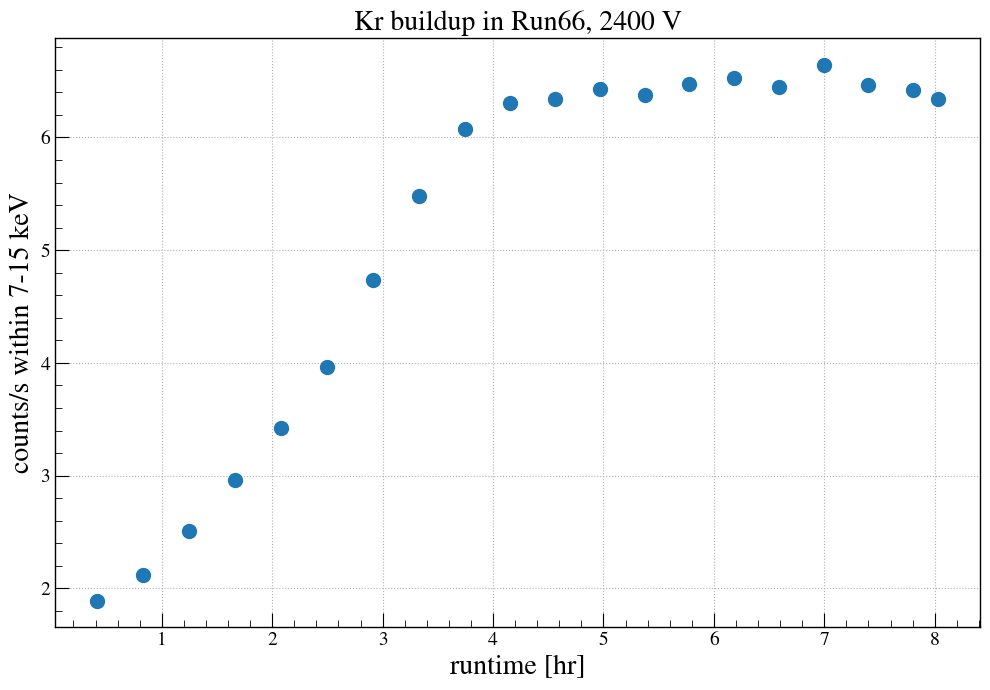

In [46]:
i = 2
df = kutils.load_dsp(run=runs[i], params=[['trapEmax']], skip_cycles=skip_cycless[i])
event_counts = []

for cycle in df.cycle.unique():
    d = df[df.cycle==cycle]
    count = d[(d.trapEmax_cal_keV>7) & (d.trapEmax_cal_keV<15)].shape[0]
    event_counts.append(count)

runtimes = df.runtime_s.unique().tolist()
# cumulative sum of runtimes
cum_runtimes = np.cumsum(runtimes)/3600

# get count rate

event_count_rate = np.array(event_counts)/np.array(runtimes) # counts/sec

plt.plot(cum_runtimes, event_count_rate, 'o')
plt.xlabel('runtime [hr]')
plt.ylabel('counts/s within 7-15 keV')
plt.title('Kr buildup in Run'+str(runs[i])+', '+str(bias_voltages[i])+' V')

pd.DataFrame({'runtime':runtimes, 'counts':event_counts})

76--kry--5.559748480930556 hrs--2023/04/26 closed turbopump valve, source open.
71--kry--6.7191916255 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
66--kry--8.02913383456389 hrs--2023/04/24 bias at 2400, closed turbo valve, krypton run
80--kry--16.670039409199997 hrs--2023/04/27 elog 623 overnight kr run at 2500 V to compare with rate at 2400 V.
86--kry--23.723893230211115 hrs--elog 636. varying temp by a few degs with cartridge heaters


(0.0, 8.0)

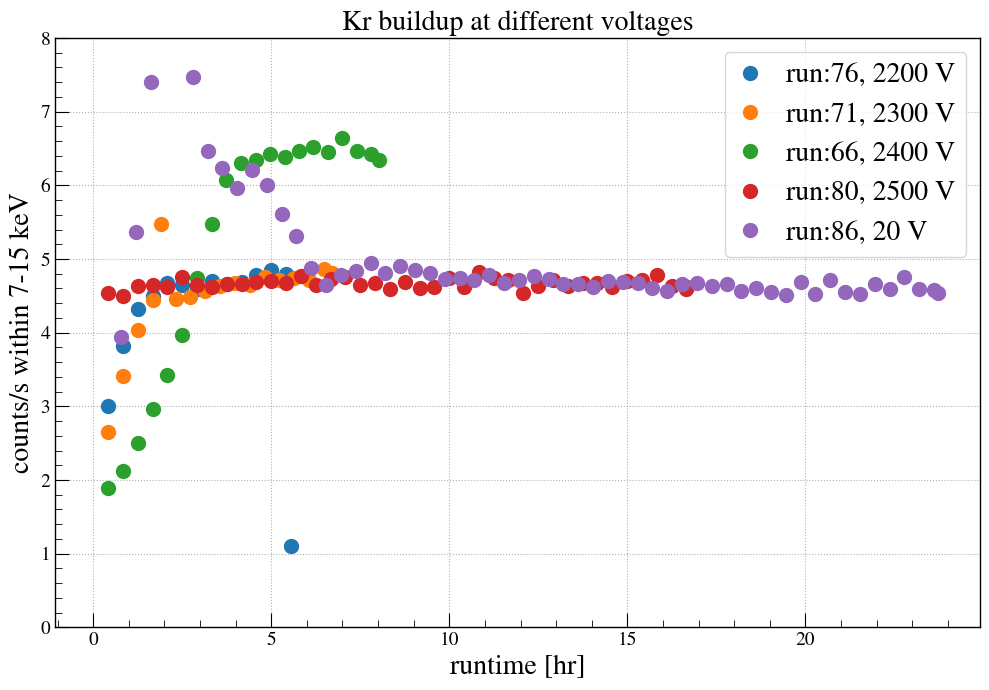

In [47]:

for i in np.arange(len(runs)):
    # if i==3:
    #     continue
    df = kutils.load_dsp(run=runs[i], params=[['trapEmax']], skip_cycles=skip_cycless[i])
    event_counts = []

    for cycle in df.cycle.unique():
        d = df[df.cycle==cycle]
        count = d[(d.trapEmax_cal_keV>7) & (d.trapEmax_cal_keV<15)].shape[0]
        event_counts.append(count)

    runtimes = df.runtime_s.unique().tolist()
    
    # cumulative sum of runtimes
    cum_runtimes = np.cumsum(runtimes)/3600

    # divide event counts by runtime to get counts/sec
    # t_half = 1.83 #hrs #not lambda*N while building up, only while decaying
    event_count_rate = np.array(event_counts)/np.array(runtimes)# counts/sec
    plt.plot(cum_runtimes, event_count_rate, 'o', label='run:'+str(runs[i])+', '+str(bias_voltages[i])+' V')
    
    plt.xlabel('runtime [hr]')
    plt.ylabel('counts/s within 7-15 keV')
plt.title('Kr buildup at different voltages')
plt.legend()
#plt.xlim(0, 8)
plt.ylim(0,8)

In [52]:
run_86_keep_cycles = np.arange(3734,3739)
run_86 = np.arange(3724,3782)
#delete run_86_keep_cycles from run_86
run_86_skip_cycles = np.setdiff1d(run_86, run_86_keep_cycles)
run_86_skip_cycles[7:15]

array([3731, 3732, 3733, 3739, 3740, 3741, 3742, 3743])

76--kry--5.559748480930556 hrs--2023/04/26 closed turbopump valve, source open.
71--kry--7.057898700166666 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
66--kry--8.02913383456389 hrs--2023/04/24 bias at 2400, closed turbo valve, krypton run
80--kry--16.670039409199997 hrs--2023/04/27 elog 623 overnight kr run at 2500 V to compare with rate at 2400 V.
86--kry--23.723893230211115 hrs--elog 636. varying temp by a few degs with cartridge heaters


(0.0, 8.0)

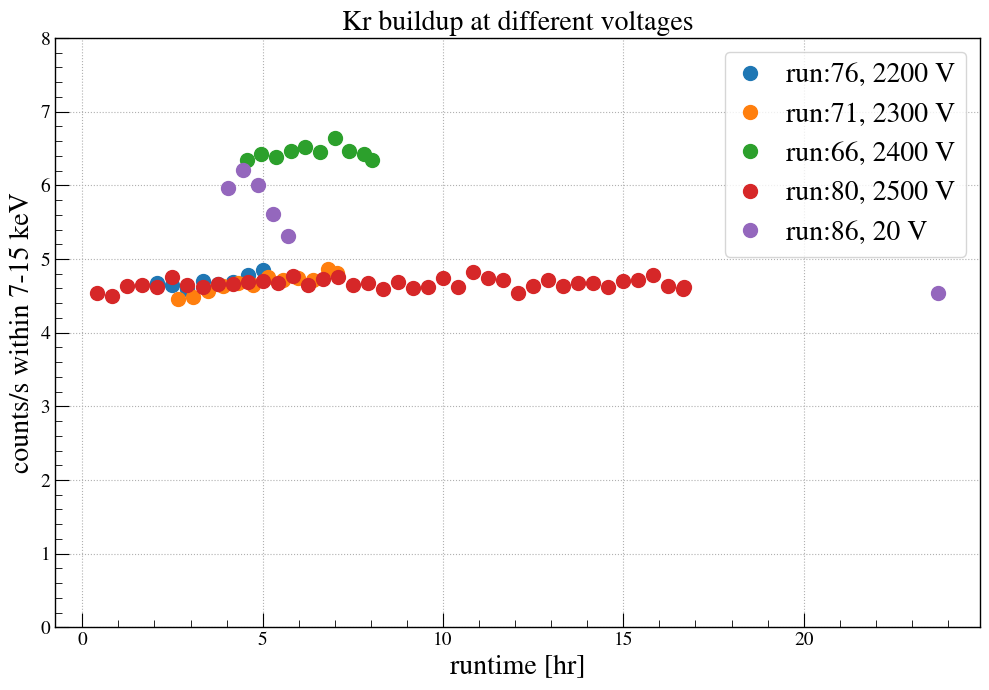

In [53]:
skip_cycless = [[3363,3364,3365,3366, 3375,3376],
               [3294,3295,3296,3297,3298,3299,3300,3301,3302],
               [3230,3231,3232,3233,3234,3235,3236,3237,3238,3239],
               [],
               run_86_skip_cycles]

for i in np.arange(len(runs)):
    # if i==3:
    #     continue
    df = kutils.load_dsp(run=runs[i], params=[['trapEmax']])
    event_counts = []
    runtimes = df.runtime_s.unique().tolist()
    cycles = df.cycle.unique()
    count_rate = []

    for cycle, runtime in zip(cycles, runtimes):
        # cycle in skip cyles then skip
        if cycle in skip_cycless[i]:
            count_rate.append(None)
            continue
        d = df[df.cycle==cycle]
        count = d[(d.trapEmax_cal_keV>7) & (d.trapEmax_cal_keV<15)].shape[0]
        event_counts.append(count)
        count_rate.append(count/runtime)

    #runtimes = df.runtime_s.unique().tolist()
    
    # cumulative sum of runtimes
    cum_runtimes = np.cumsum(runtimes)/3600

    # divide event counts by runtime to get counts/sec
    # t_half = 1.83 #hrs #not lambda*N while building up, only while decaying
    #event_count_rate = np.array(event_counts)/np.array(runtimes)# counts/sec
    plt.plot(cum_runtimes, count_rate, 'o', label='run:'+str(runs[i])+', '+str(bias_voltages[i])+' V')
    
    plt.xlabel('runtime [hr]')
    plt.ylabel('counts/s within 7-15 keV')
plt.title('Kr buildup at different voltages')
plt.legend()
plt.ylim(0,8)

# energy spectra at different bias voltages

## bkg not subtracted, just shown

In [25]:
d, r = kutils.load_dsp(run = 92, skip_cycles=[3876,3877])
d

/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3865_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3866_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3867_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3868_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3869_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3870_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3871_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3872_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3873_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3874_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3875_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3878_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3879_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3880_dsp.lh5
/globa

,trapEmax,tp_0,stp_20,trapEmax_cal_keV,pulse_rise_time_ns,run,cycle,runtime_s
0,320.870605,39310.0,39850.0,138.427231,540.0,92,3865,1498.839063
1,207.395782,39070.0,39760.0,89.519585,690.0,92,3865,1498.839063
2,208.967712,39770.0,39790.0,90.197090,20.0,92,3865,1498.839063
3,1207.377319,39260.0,40110.0,520.511658,850.0,92,3865,1498.839063
4,15.734752,38070.0,38060.0,6.913678,-10.0,92,3865,1498.839063
...,...,...,...,...,...,...,...,...
9772,492.321014,39510.0,39920.0,212.322357,410.0,92,3906,135.270012
9773,145.140198,38770.0,39760.0,62.687424,990.0,92,3906,135.270012
9774,3457.565186,39550.0,40340.0,1490.342529,790.0,92,3906,135.270012
9775,318.954742,39310.0,39850.0,137.601501,540.0,92,3906,135.270012


In [28]:
d.runtime_s.unique().sum()/3600

16.280063133747223

total runtime: 64.32554235333333 mins


(array([0.        , 0.        , 0.        , ..., 0.10493499, 0.11011696,
        0.08550258]),
 array([ 0. ,  0.2,  0.4, ..., 49.4, 49.6, 49.8]),
 array([ 0,  0,  0, ..., 81, 85, 66]))

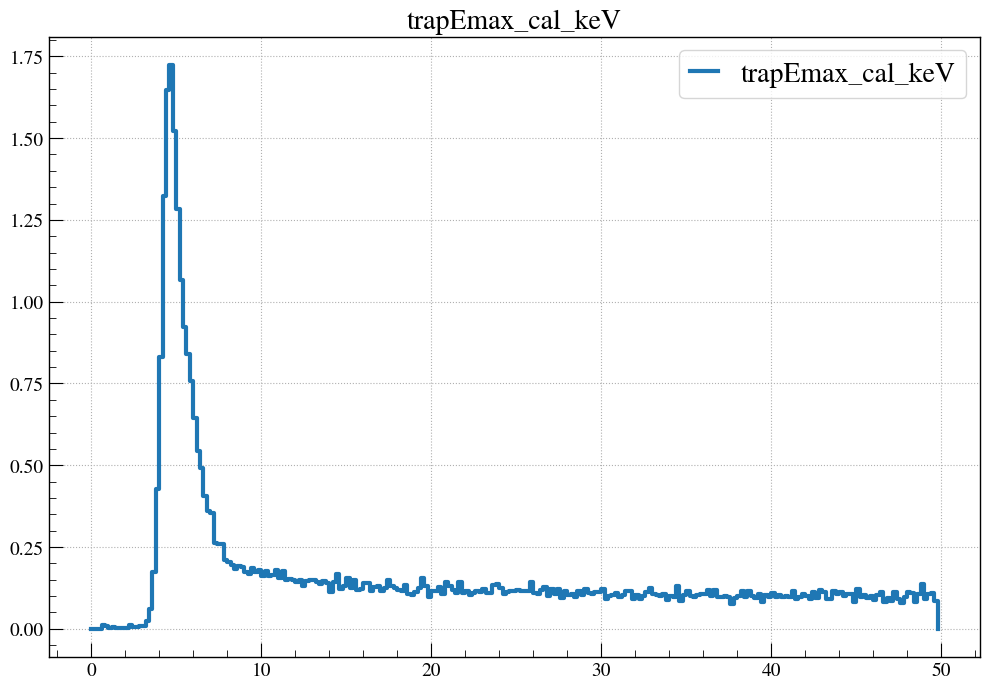

In [24]:
kutils.get_1D_hist(df_bkg['trapEmax_cal_keV'], df_bkg['runtime_s'], normalized=True, range=(0,50), binsize=0.2)

In [ ]:
runs = [89, 92] #86 is temp test, only keep 3734-3738(inclusive)
bias_voltages = [2700, 2400]

skip_cycless = [[3805],
               [3876,3877],
               ]




Text(0, 0.5, 'counts/sec/keV')

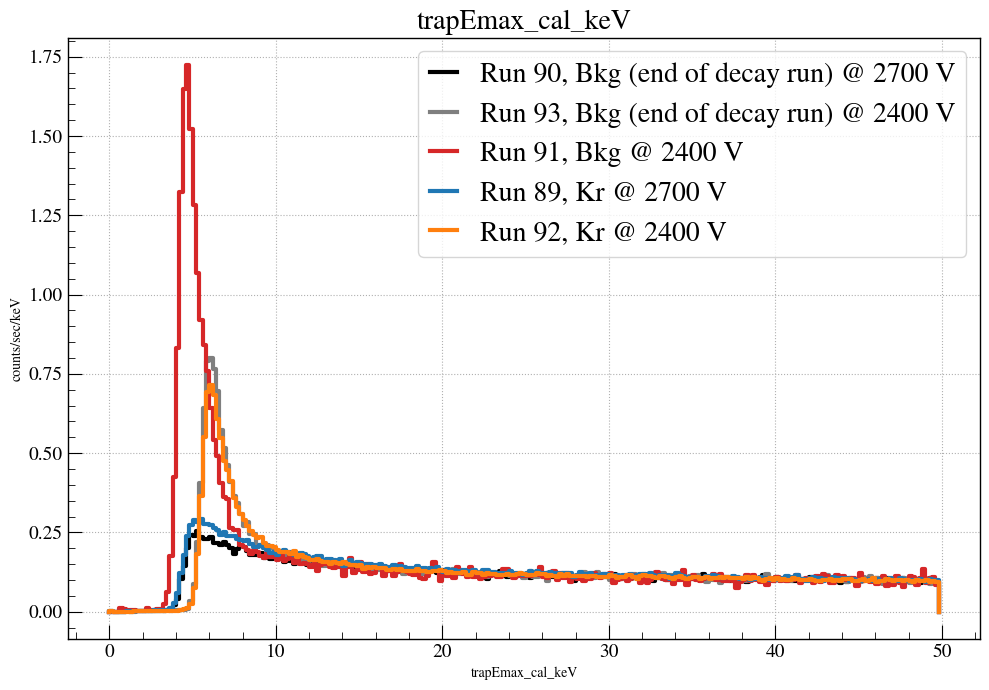

In [22]:
range = (0,50) # keV
binsize = 0.2 # keV

normalized = True
verbose = False


bkg_run = 90
bkg_skip_cycles = np.arange(3833,3850+1) # [3864]
df_bkg, bkg_runtime = kutils.load_dsp(run=bkg_run, params=[['trapEmax']], skip_cycles=bkg_skip_cycles, verbose=verbose)
kutils.get_1D_hist(df_bkg.trapEmax_cal_keV, df_bkg.runtime_s, range=range, binsize=binsize, label='Run '+str(bkg_run)+', Bkg (end of decay run) @ 2700 V', color='k', normalized=normalized, verbose=verbose)

bkg_run = 93
bkg_skip_cycles = np.arange(3907, 3921+1)
df_bkg, bkg_runtime = kutils.load_dsp(run=bkg_run, params=[['trapEmax']], skip_cycles=bkg_skip_cycles, verbose=verbose)
kutils.get_1D_hist(df_bkg.trapEmax_cal_keV, df_bkg.runtime_s, range=range, binsize=binsize, label='Run '+str(bkg_run)+', Bkg (end of decay run) @ 2400 V', color='tab:gray', normalized=normalized, verbose=verbose)

bkg_run = 91
bkg_skip_cycles = None
df_bkg, bkg_runtime = kutils.load_dsp(run=bkg_run, params=[['trapEmax']], skip_cycles=bkg_skip_cycles, verbose=verbose)
kutils.get_1D_hist(df_bkg.trapEmax_cal_keV, df_bkg.runtime_s, range=range, binsize=binsize, label='Run '+str(bkg_run)+', Bkg @ 2400 V', color='tab:red', normalized=normalized, verbose=verbose)


for run, skip_cycle, bias_voltage in zip(runs, skip_cycless, bias_voltages):
    df, runtime = kutils.load_dsp(run=run, params=[['trapEmax']], skip_cycles=skip_cycle, verbose=verbose)
    kutils.get_1D_hist(df.trapEmax_cal_keV, df.runtime_s, range=range, binsize=binsize, label='Run '+str(run)+', Kr @ '+str(bias_voltage)+' V', normalized=normalized, verbose=verbose)

plt.legend()
plt.xlabel('trapEmax_cal_keV')
plt.ylabel('counts/sec/keV')


In [42]:
df_bkg.runtime_s.unique()

array([1269.55969081, 1090.58165796, 1499.39119243])

## bkg subtracted energy spectra

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2784498, 5) kry
total runtime: 260.9900218685 mins


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


total runtime: 657.1306335151666 mins
(4177362, 5) kry
total runtime: 260.9900218685 mins
total runtime: 976.8037880248335 mins


Text(0.5, 1.0, 'bkg subtracted spectra')

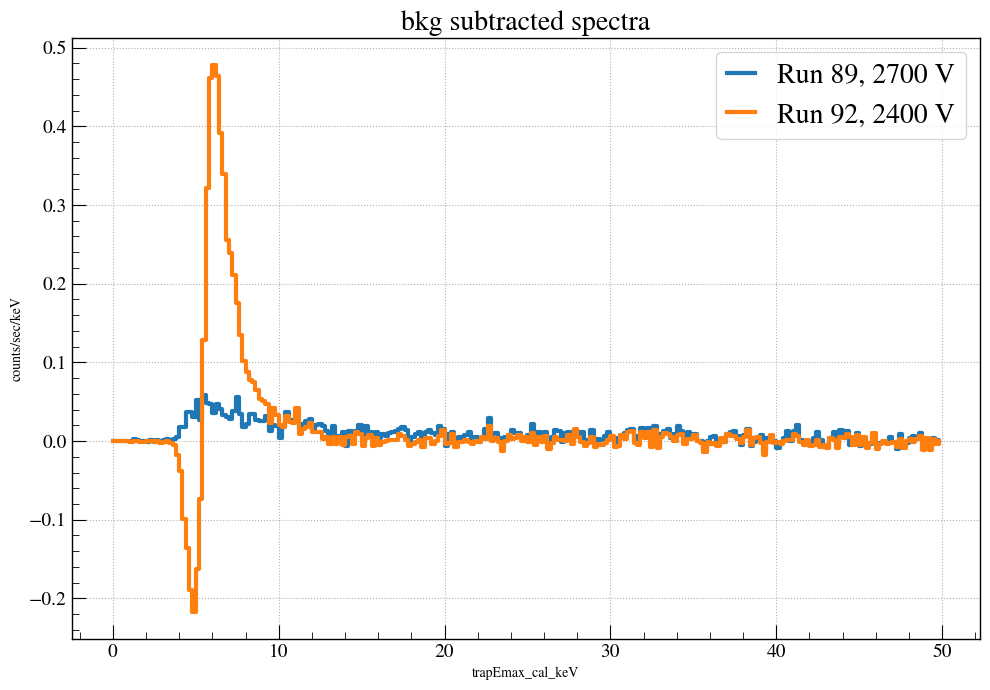

In [54]:
range = (0,50) # keV
binsize = 0.2 # keV


df_bkg, bkg_runtime = kutils.load_dsp(run=bkg_run, params=[['trapEmax']], skip_cycles=bkg_skip_cycles, verbose=False)
#kutils.get_1D_hist(df_bkg.trapEmax_cal_keV, df_bkg.runtime_s, range=range, binsize=binsize, label='Run '+str(bkg_run)+', Bkg', color='k')

for run, skip_cycle, bias_voltage in zip(runs, skip_cycless, bias_voltages):
    df, runtime = kutils.load_dsp(run=run, params=[['trapEmax']], skip_cycles=skip_cycle, verbose=False)
    print(df.shape, runtime)
    kutils.get_subtracted_1D_hist(df.trapEmax_cal_keV, df.runtime_s, df_bkg.trapEmax_cal_keV, df_bkg.runtime_s, range=range, binsize=binsize, label='Run '+str(run)+', '+str(bias_voltage)+' V')

plt.legend()
plt.xlabel('trapEmax_cal_keV')
plt.ylabel('counts/sec/keV')
plt.title('bkg subtracted spectra')


## why excess in for 2300V (run 71)?
- Normalization of problem?

71--kry--7.057898700166666 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
total runtime: 99.97727123083334 mins
total runtime: 239.40333130566665 mins


Text(0.5, 1.0, 'run 71, without the weird cycles')

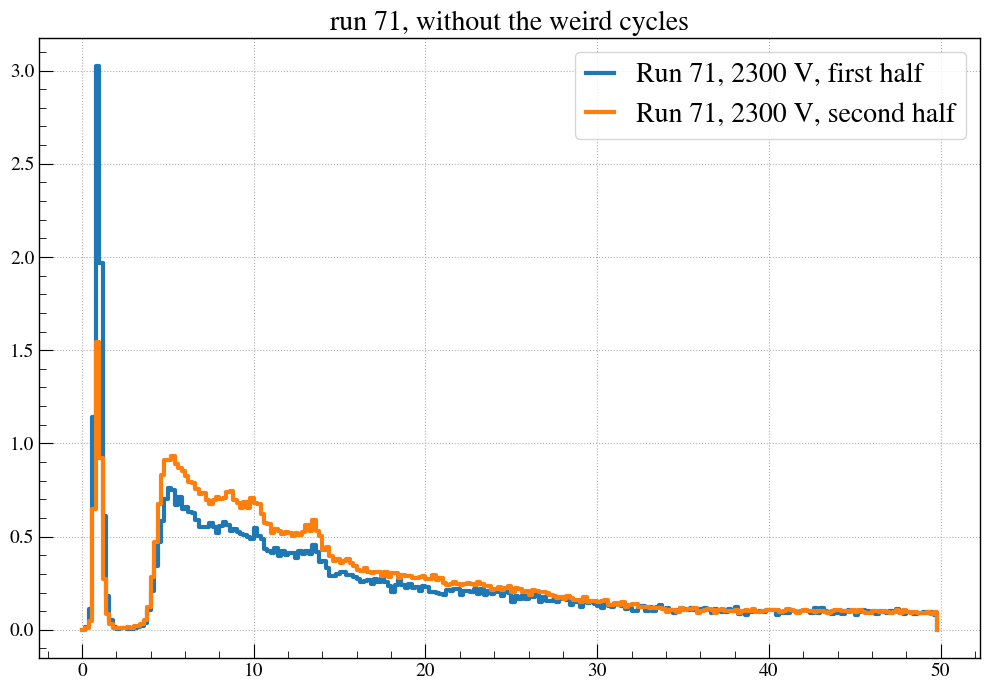

In [8]:
df_71 = kutils.load_dsp(run=71, params=[['trapEmax']])

# df_71_1 = df_71[df_71.cycle<3300]
# df_71_2 = df_71[(df_71.cycle>3300) & (df_71.cycle<3308)]
# df_71_3 = df_71[df_71.cycle>3308]

df_71_1 = df_71[df_71.cycle<3298]
df_71_2 = df_71[(df_71.cycle>3304)]

kutils.get_1D_hist(df_71_1.trapEmax_cal_keV, df_71_1.runtime_s, range=range, binsize=binsize, label='Run 71, 2300 V, first half')

kutils.get_1D_hist(df_71_2.trapEmax_cal_keV, df_71_2.runtime_s, range=range, binsize=binsize, label='Run 71, 2300 V, second half')

#kutils.get_1D_hist(df_71_3.trapEmax_cal_keV, df_71_3.runtime_s, range=range, binsize=binsize, label='Run 71, 2300 V, third half')

plt.title('run 71, without the weird cycles')

71--kry--6.7191916255 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
71--kry--7.057898700166666 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
total runtime: 403.15149753 mins
total runtime: 423.47392200999997 mins


(array([0.00059036, 0.01613637, 0.07477832, ..., 0.12003888, 0.12141637,
        0.11728388]),
 array([ 0. ,  0.2,  0.4, ..., 49.4, 49.6, 49.8]),
 array([  3,  82, 380, ..., 610, 617, 596]))

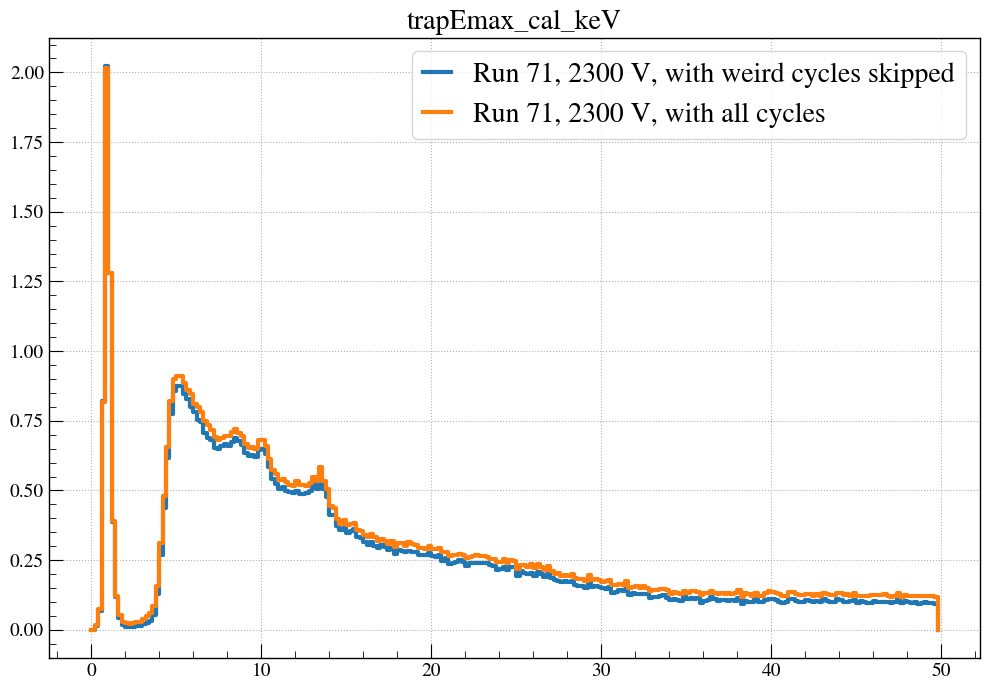

In [9]:
df_71_skipped_cycles = kutils.load_dsp(run=71, params=[['trapEmax']], skip_cycles=[3298,3299,3300,3301])
df_71_all_cycles = kutils.load_dsp(run=71, params=[['trapEmax']])

kutils.get_1D_hist(df_71_skipped_cycles.trapEmax_cal_keV, df_71_skipped_cycles.runtime_s, range=range, binsize=binsize, label='Run 71, 2300 V, with weird cycles skipped')

kutils.get_1D_hist(df_71_all_cycles.trapEmax_cal_keV, df_71_all_cycles.runtime_s, range=range, binsize=binsize, label='Run 71, 2300 V, with all cycles')

# pulse rise time with different bias voltages

76--kry--3.3319772082777783 hrs--2023/04/26 closed turbopump valve, source open.
total runtime: 199.9186324966667 mins
71--kry--4.82314448785 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
total runtime: 289.38866927099997 mins
66--kry--3.879059641847222 hrs--2023/04/24 bias at 2400, closed turbo valve, krypton run
total runtime: 232.74357851083332 mins
80--kry--16.670039409199997 hrs--2023/04/27 elog 623 overnight kr run at 2500 V to compare with rate at 2400 V.
total runtime: 1000.202364552 mins


Text(0.5, 1.0, 'pulse rise time at different voltages')

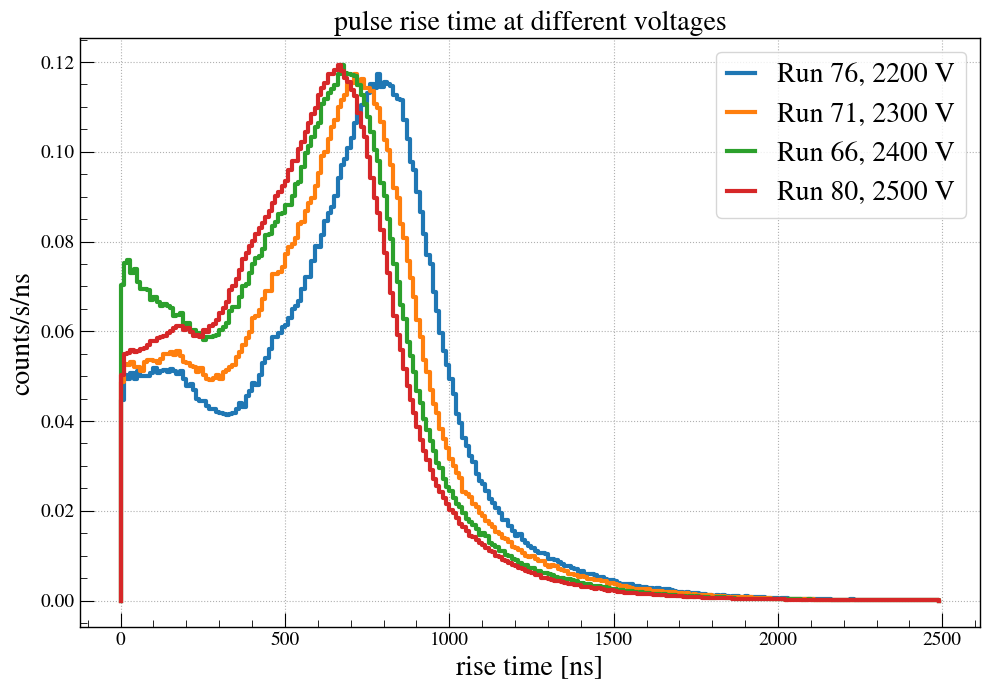

In [34]:
# #runs = [66,71,76,80]
# runs = [76, 71, 66, 80]
# #bias_voltages = [2400, 2300, 2200, 2500]
# bias_voltages = [2200, 2300, 2400, 2500]
# skip_cycless = [[],
#                [3298,3299,3300,3301],
#                [],
#                []]
binsize = 10
range= (0, 2500)
for i in np.arange(len(runs)):
    df = kutils.load_dsp(run=runs[i], params=[['trapEmax','tp_0','stp_20']], skip_cycles=skip_cycless[i])
    hist, bins, _ = kutils.get_1D_hist(df.pulse_rise_time_ns, df.runtime_s, range=range, binsize=binsize, label='Run '+str(runs[i])+', '+str(bias_voltages[i])+' V')

plt.xlabel('rise time [ns]')
plt.ylabel('counts/s/ns')
plt.title('pulse rise time at different voltages')

## fit gaussian and see if there's any trend

76--kry--3.3319772082777783 hrs--2023/04/26 closed turbopump valve, source open.
total runtime: 199.9186324966667 mins
71--kry--4.82314448785 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
total runtime: 289.38866927099997 mins
66--kry--3.879059641847222 hrs--2023/04/24 bias at 2400, closed turbo valve, krypton run
total runtime: 232.74357851083332 mins
80--kry--16.670039409199997 hrs--2023/04/27 elog 623 overnight kr run at 2500 V to compare with rate at 2400 V.
total runtime: 1000.202364552 mins
[784.1706095102413, 716.3302804370886, 675.2251166226418, 650.9520752952262]


Text(0.5, 1.0, 'bias voltage test, Kr runs only, C9')

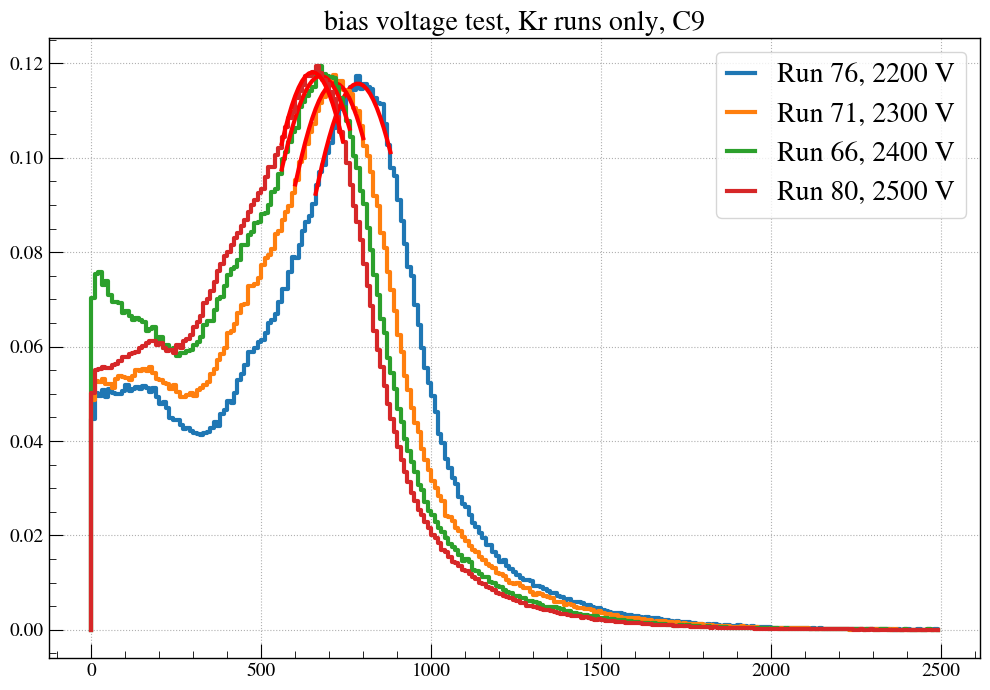

In [35]:
prt = []
for run, skip_cycles, bias_voltage in zip(runs, skip_cycless, bias_voltages):
    df = kutils.load_dsp(run=run, params=[['trapEmax','tp_0','stp_20']], skip_cycles=skip_cycles)
    hist, bins, _ = kutils.get_1D_hist(df.pulse_rise_time_ns, df.runtime_s, range=range, binsize=binsize, label='Run '+str(run)+', '+str(bias_voltage)+' V')

    fit_params = kutils.gaussian_fit_binned(bins[:-1], hist, plot=True)
    prt.append(fit_params['mu'])
print(prt)
plt.title('bias voltage test, Kr runs only, C9')

[2200, 2300, 2400, 2500] [784.1706095102413, 716.3302804370886, 675.2251166226418, 650.9520752952262]
(array([ 7.74385044e+03, -5.55991642e+00,  1.08918205e-03,  1.00000000e+00]), array([[inf, inf, inf, inf],
       [inf, inf, inf, inf],
       [inf, inf, inf, inf],
       [inf, inf, inf, inf]]))


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


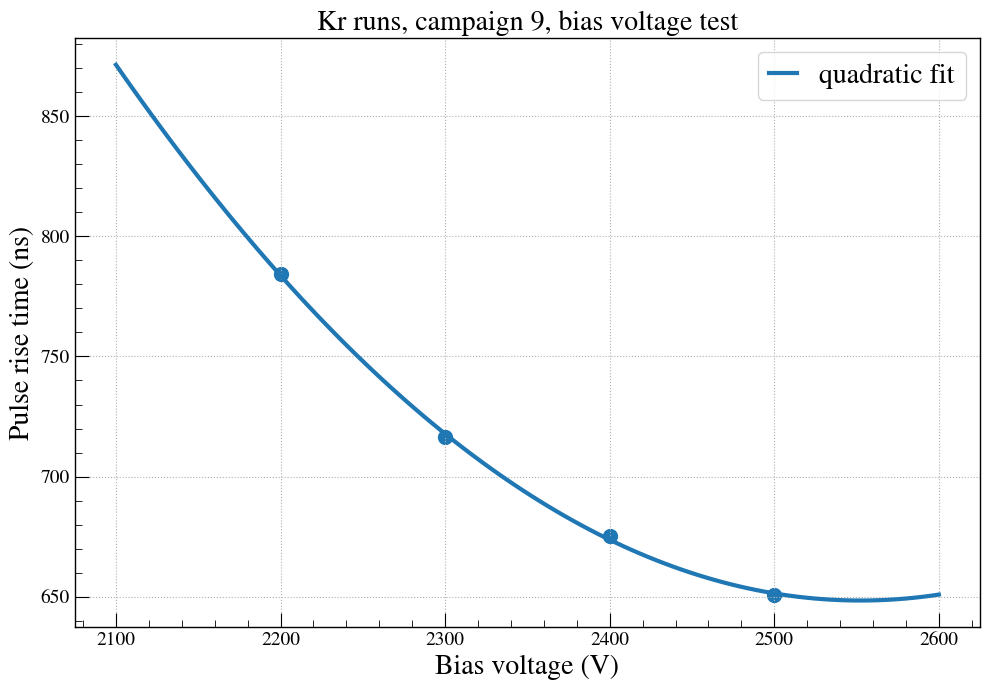

In [36]:
plt.scatter(bias_voltages, prt)
plt.xlabel('Bias voltage (V)')
plt.ylabel('Pulse rise time (ns)')
plt.title('Kr runs, campaign 9, bias voltage test')
print(bias_voltages, prt)

# fit a quadratic
def quadratic(x, p0, p1, p2, p3):
    return p0 + p1*x + p2*x**2
fit_params = curve_fit(quadratic, bias_voltages, prt)
print(fit_params)
x = np.linspace(2100, 2600, 100)
y = quadratic(x, *fit_params[0])
plt.plot(x, y, label='quadratic fit')
plt.legend()

## 2D hist of risetime vs energy

/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3806_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3807_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3808_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3809_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3810_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3811_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3812_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3813_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3814_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3815_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3816_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3817_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3818_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run89_cyc3819_dsp.lh5
/globa

/global/homes/f/fnafis/krstc/krstc_utils.py:459: RuntimeWarning: divide by zero encountered in log
  if log:


/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3865_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3866_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3867_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3868_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3869_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3870_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3871_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3872_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3873_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3874_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3875_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3878_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3879_dsp.lh5
/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run92_cyc3880_dsp.lh5
/globa

/global/homes/f/fnafis/krstc/krstc_utils.py:459: RuntimeWarning: divide by zero encountered in log
  if log:


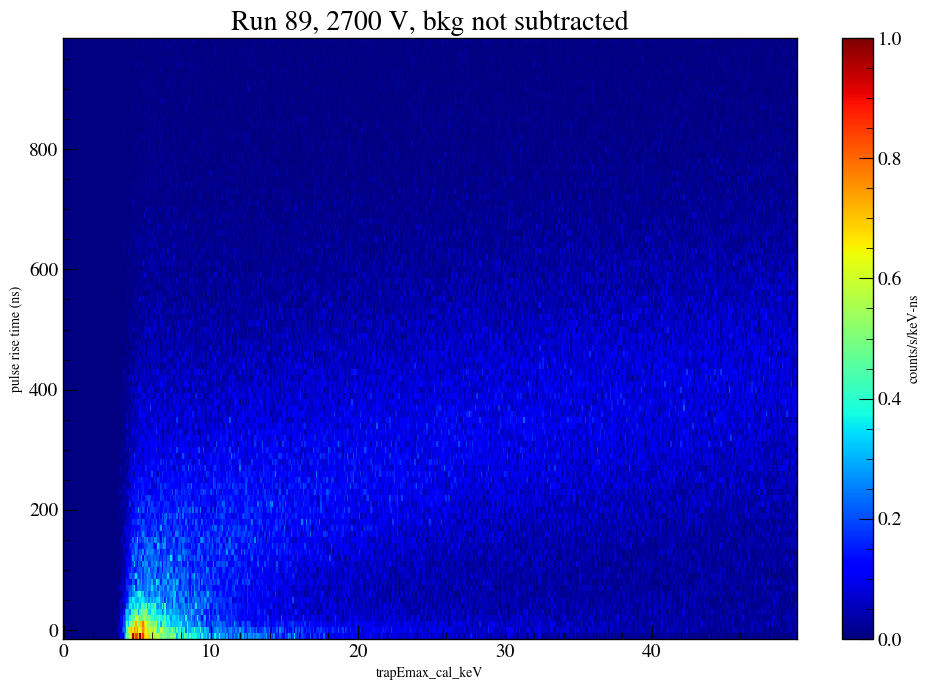

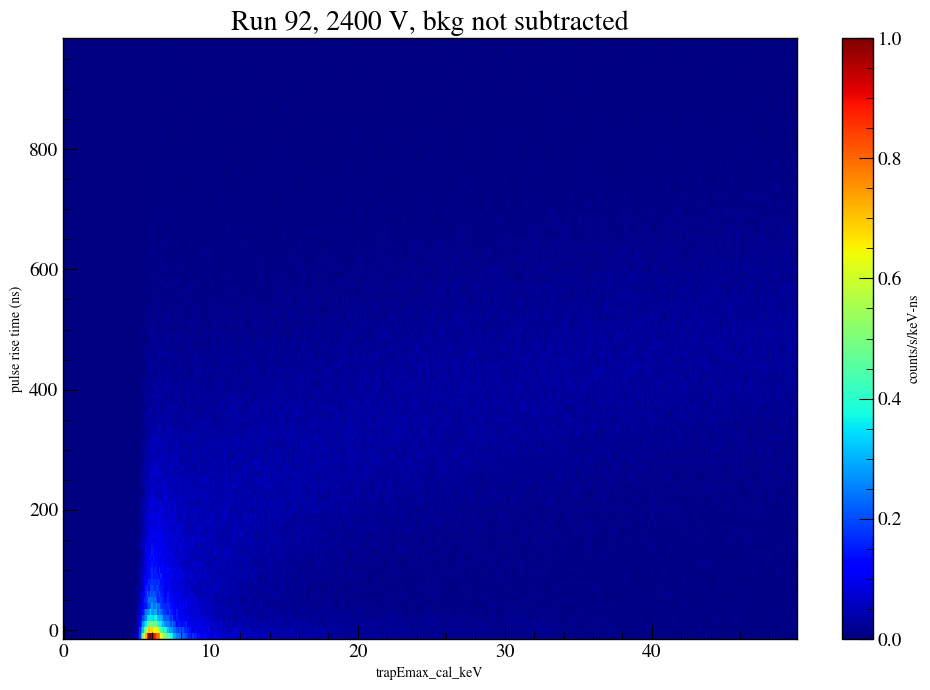

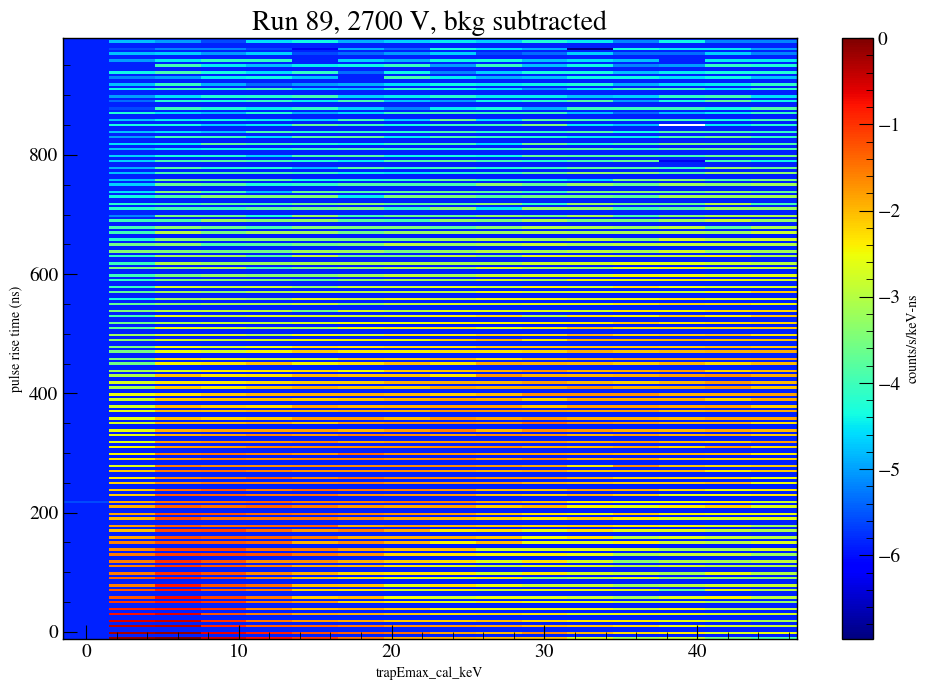

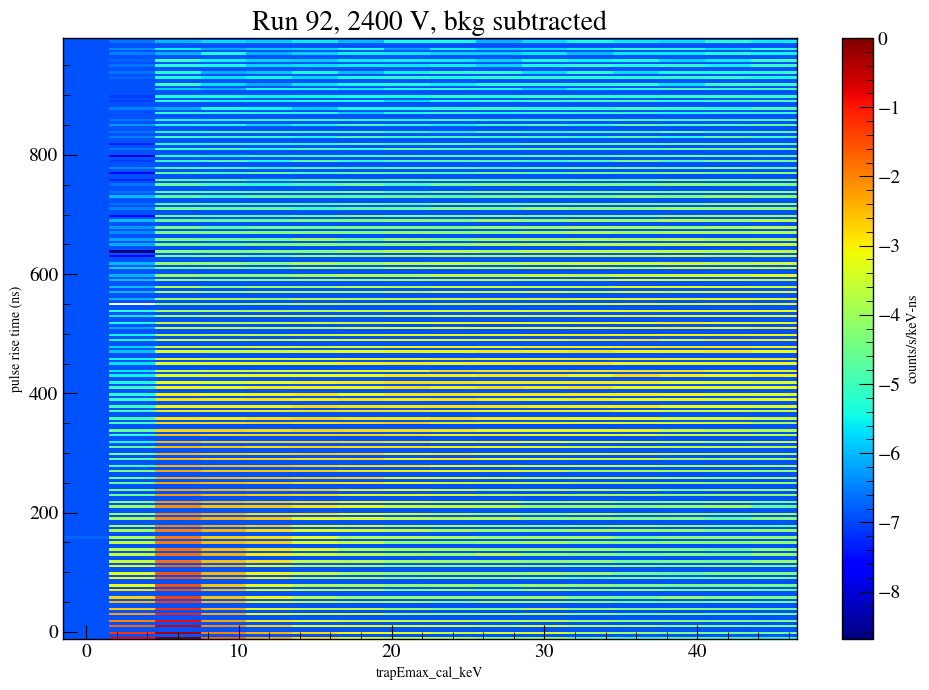

In [57]:

#bkg not subtracted
for i in np.arange(len(runs)):
    df, runtime = kutils.load_dsp(run=runs[i], params=[['trapEmax','tp_0','stp_20']], skip_cycles=skip_cycless[i])
    plt.figure()
    a = kutils.get_2D_hist(df.trapEmax_cal_keV, df.pulse_rise_time_ns, df.runtime_s, ranges=[[0,50], [-10,1000]], binsizes=[0.1,10], normalized=True, vlim=(0,1), log=False, cbar_label='counts/s/keV-ns', plot=True)
    plt.xlabel('trapEmax_cal_keV')
    plt.ylabel('pulse rise time (ns)')
    plt.title('Run '+str(runs[i])+', '+str(bias_voltages[i])+' V, bkg not subtracted')
    # if i==4:
    #     continue

#bkg subtracted


df_bkg, bkg_runtime = kutils.load_dsp(run=bkg_run, params=[['trapEmax','tp_0','stp_20']], skip_cycles=bkg_skip_cycles)
for i in np.arange(len(runs)):
    df, runtime = kutils.load_dsp(run=runs[i], params=[['trapEmax','tp_0','stp_20']], skip_cycles=skip_cycless[i])
    plt.figure()
    a = kutils.get_subtracted_2D_hist(df.trapEmax_cal_keV, df.pulse_rise_time_ns, df.runtime_s, df_bkg.trapEmax_cal_keV, df_bkg.pulse_rise_time_ns, df_bkg.runtime_s, ranges=[[0,50], [-10,1000]], binsizes=[3,4], normalized=True, vlim=(0,1), log=True, cbar_label='counts/s/keV-ns', plot=True)
    plt.xlabel('trapEmax_cal_keV')
    plt.ylabel('pulse rise time (ns)')
    plt.title('Run '+str(runs[i])+', '+str(bias_voltages[i])+' V, bkg subtracted')
    if i==4:
        continue

## check some wfs

76--kry--5.559748480930556 hrs--2023/04/26 closed turbopump valve, source open.
71--kry--6.7191916255 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
66--kry--8.02913383456389 hrs--2023/04/24 bias at 2400, closed turbo valve, krypton run
80--kry--16.670039409199997 hrs--2023/04/27 elog 623 overnight kr run at 2500 V to compare with rate at 2400 V.


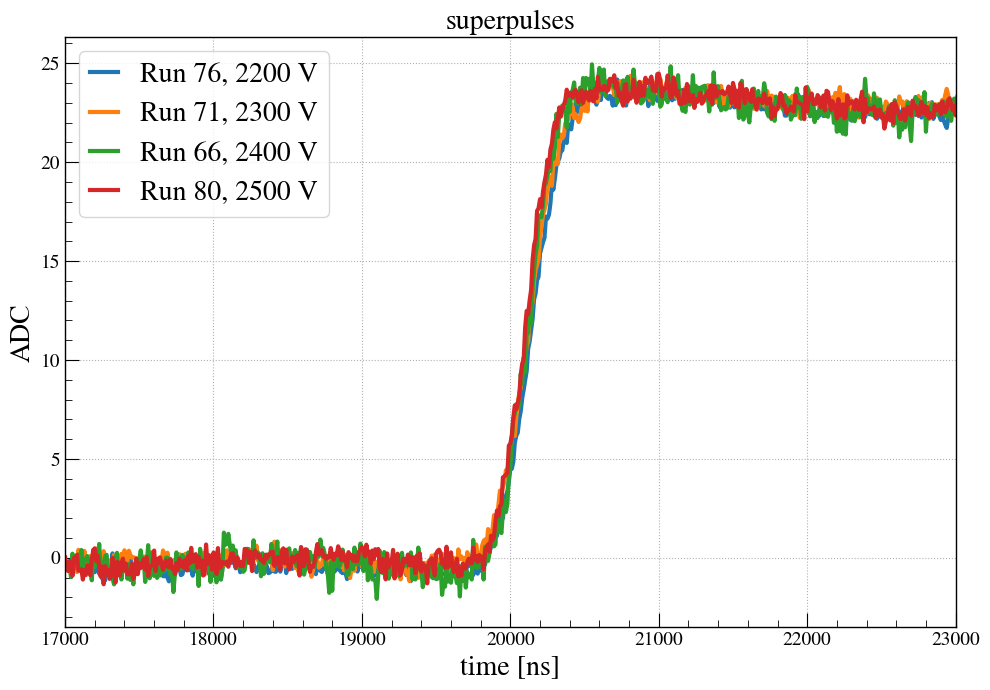

In [3]:
for i in np.arange(len(runs)):
    if i==4:
        break
    df = kutils.load_dsp(run=runs[i], params=[['trapEmax','tp_0','stp_20']], skip_cycles=skip_cycless[i])
    df = df[(df.trapEmax_cal_keV>9) & (df.trapEmax_cal_keV<11) & (df.pulse_rise_time_ns>0) & (df.pulse_rise_time_ns<100)]

    # plot superpulse
    kutils.get_superpulse(df,
                          nwfs = 4000,
                          shift_to=20000,
                          superpulse_label='Run '+str(runs[i])+', '+str(bias_voltages[i])+' V')
    plt.ylabel('ADC')
    plt.title('superpulses')
    

76--kry--5.559748480930556 hrs--2023/04/26 closed turbopump valve, source open.
       trapEmax_cal_keV  pulse_rise_time_ns  run  cycle
37123         16.018930               130.0   76   3375
46826         16.812906               120.0   76   3374
40196          8.241092               160.0   76   3372




Text(0.5, 1.0, 'Run 80, 2200 V')

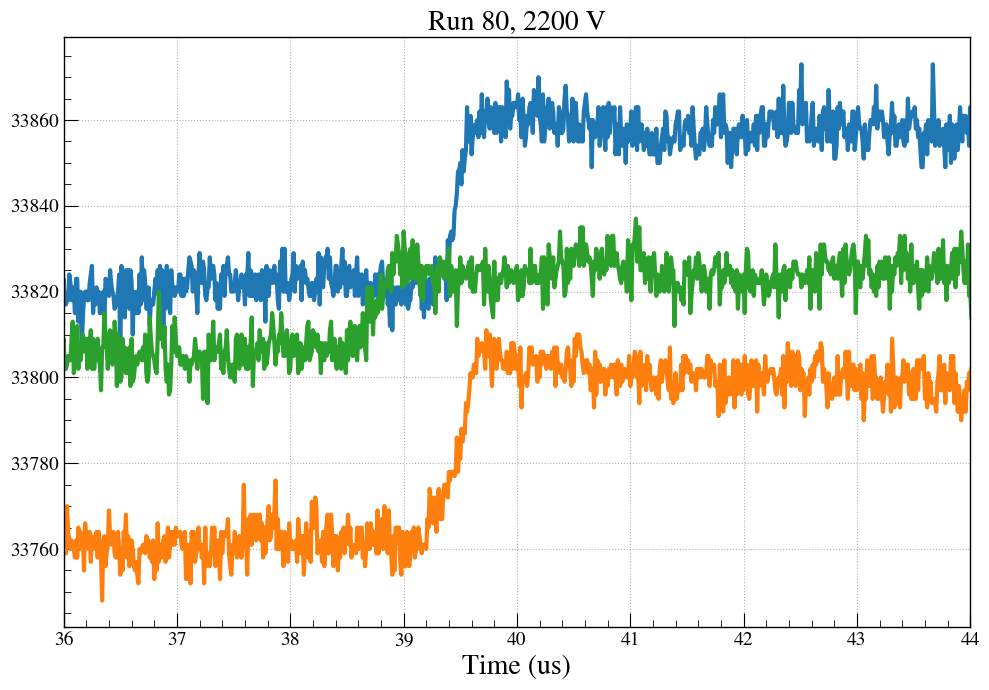

In [16]:
# runs = [76, 71, 66, 80]
# bias_voltages = [2200, 2300, 2400, 2500]
# skip_cycless = [[],
#                [3298,3299,3300,3301],
#                [],
#                []]
i = 0
df = kutils.load_dsp(run=runs[i], params=[['trapEmax','tp_0','stp_20']], skip_cycles=skip_cycless[i])
d = df[(df.pulse_rise_time_ns>100) & (df.pulse_rise_time_ns<250)]
plt.figure()
d = d[(d.trapEmax_cal_keV>5) & (d.trapEmax_cal_keV<50)]

kutils.get_raw_wfs(d, display_params=['trapEmax_cal_keV', 'pulse_rise_time_ns'])
plt.title('Run '+str(run)+', '+str(bias_voltages[i])+' V')

76--kry--5.559748480930556 hrs--2023/04/26 closed turbopump valve, source open.
       trapEmax_cal_keV  pulse_rise_time_ns  run  cycle
74107         10.234793               130.0   76   3370
15945         12.229446               140.0   76   3363
32303          7.897605               120.0   76   3364


71--kry--6.7191916255 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
        trapEmax_cal_keV  pulse_rise_time_ns  run  cycle
51709          12.302422               160.0   71   3294
111574         14.925495               160.0   71   3311
28893           9.500970               150.0   71   3308


66--kry--8.02913383456389 hrs--2023/04/24 bias at 2400, closed turbo valve, krypton run
       trapEmax_cal_keV  pulse_rise_time_ns  run  cycle
75194         13.360898               150.0   66   3248
25643          7.133371               240.0   66   3248
56538         13.789212               240.0   66   3248


80--kry--16.670039409199997 hrs--2023/04/27 elog 623 ove

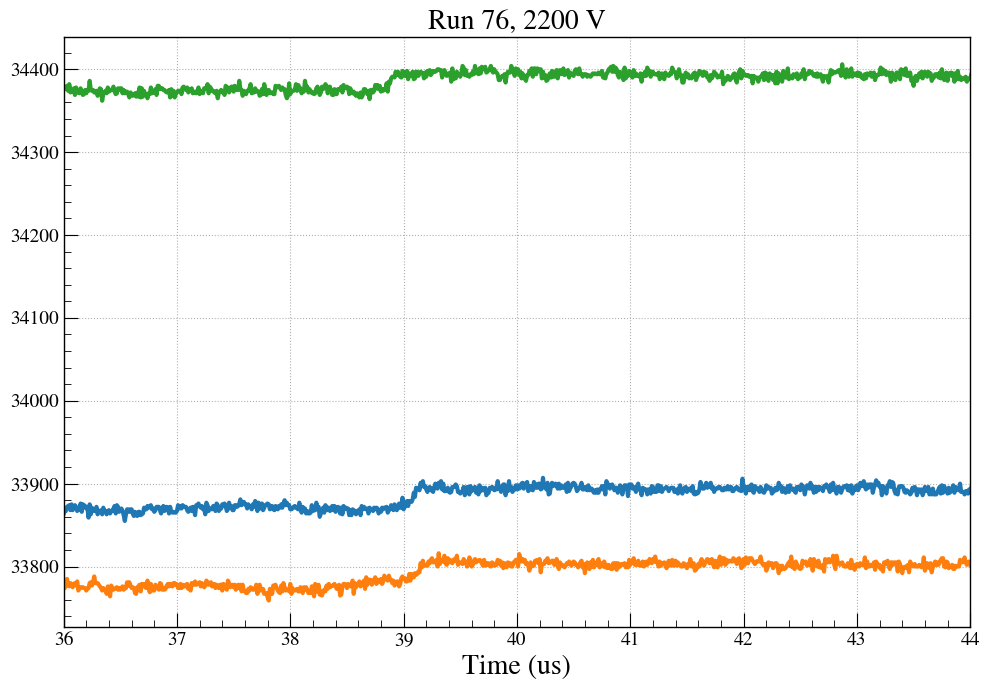

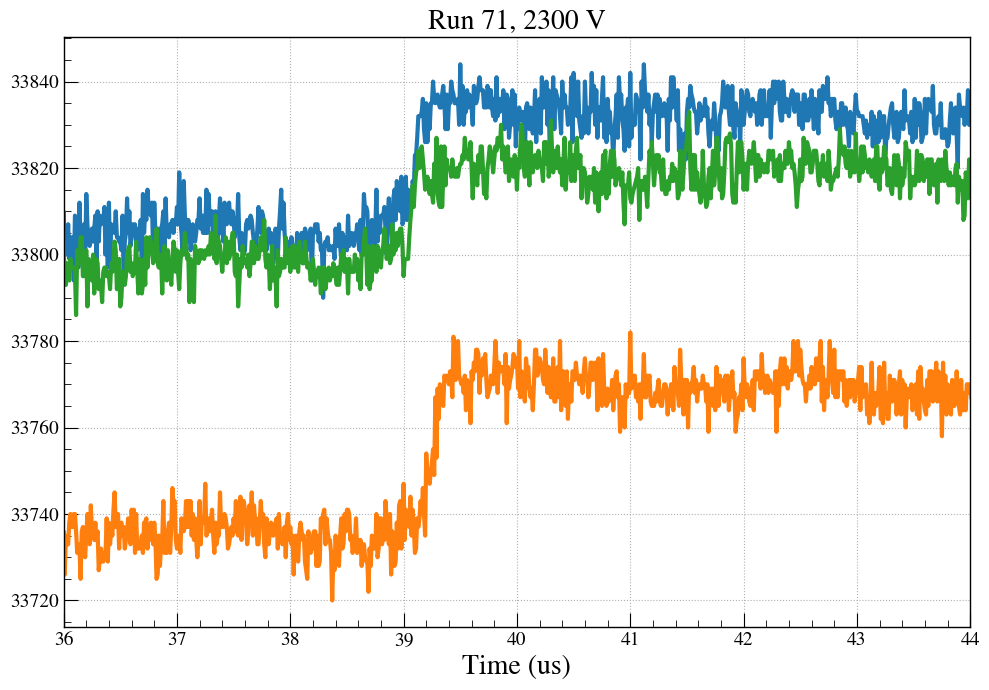

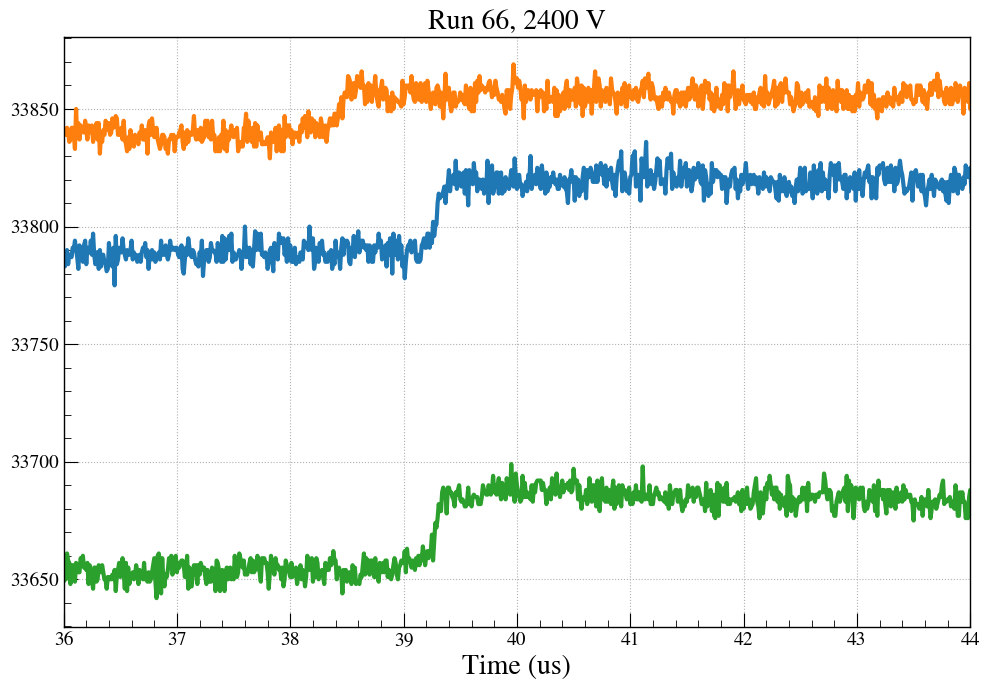

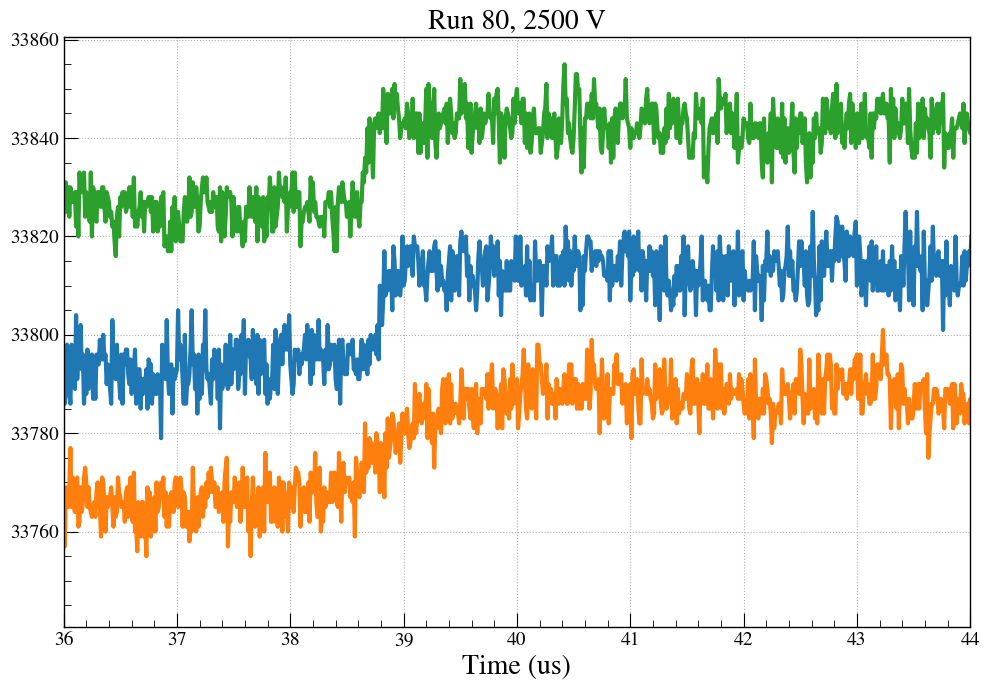

In [17]:
#prt_cut = [100,250]
# make a 2x2 plot
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# row=0
# column=0
for run, skip_cycles, bias_voltage in zip(runs, skip_cycless, bias_voltages):
    df = kutils.load_dsp(run=run, params=[['trapEmax','tp_0','stp_20']], skip_cycles=skip_cycles)
    d = df[(df.pulse_rise_time_ns>100) & (df.pulse_rise_time_ns<250)]
    plt.figure()
    d = d[(d.trapEmax_cal_keV>7) & (d.trapEmax_cal_keV<15)]

    kutils.get_raw_wfs(d, display_params=['trapEmax_cal_keV', 'pulse_rise_time_ns'])
    plt.title('Run '+str(run)+', '+str(bias_voltage)+' V')
    # plot 

# pulse rise time vs trapEmax_cal 2d hist

# baselines at different voltages

76--kry--3.3319772082777783 hrs--2023/04/26 closed turbopump valve, source open.
range: (-0.0011991780018433928, 0.0009244797052815559)
binsize: 2.1236577071249487e-05
total runtime: 199.9186324966667 mins
71--kry--4.82314448785 hrs--2023/04/25, bias 2300 V, closed turbopump valve, source still open
range: (-0.0012349140364676713, 0.0009379629627801478)
binsize: 2.1728769992478187e-05
total runtime: 289.38866927099997 mins
66--kry--3.879059641847222 hrs--2023/04/24 bias at 2400, closed turbo valve, krypton run
range: (-0.0011902512051165104, 0.0009146769298240542)
binsize: 2.1049281349405648e-05
total runtime: 232.74357851083332 mins
80--kry--16.670039409199997 hrs--2023/04/27 elog 623 overnight kr run at 2500 V to compare with rate at 2400 V.
range: (-0.0011659931624308228, 0.0008960828999988735)
binsize: 2.062076062429696e-05
total runtime: 1000.202364552 mins


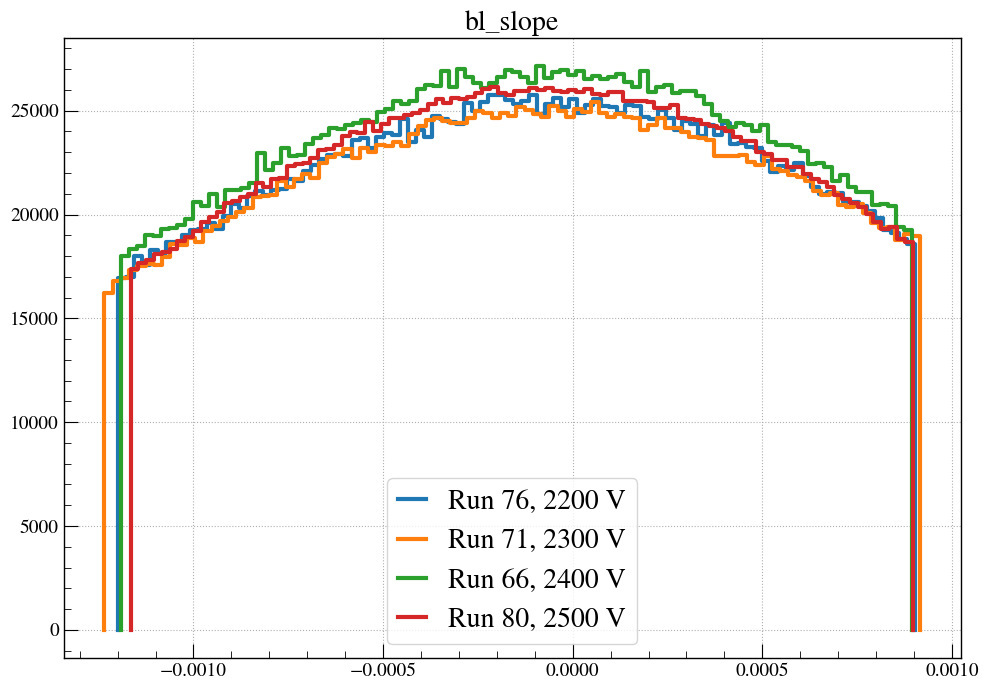

In [33]:
#binsize = 10
#range= (30000, )
range = None
binsize = None
for run, skip_cycles, bias_voltage in zip(runs, skip_cycless, bias_voltages):
    df = kutils.load_dsp(run=run, params=[['trapEmax','bl_slope']], skip_cycles=skip_cycles)
    hist, bins, _ = kutils.get_1D_hist(df.bl_slope, df.runtime_s, range=range, binsize=binsize, label='Run '+str(run)+', '+str(bias_voltage)+' V')

In [19]:
# A_avg spectrums
for run, bv in zip(runs, bias_voltages):
    runtime, t, d = kutils.load_dsp(run=run, params=[['A_avg']], verbose=False)
    binsize = 1
    range= (0, 400)
    #print(d.pulse_rise_time.describe())
    h, b, v = pgh.get_hist(d['A_avg'], bins=np.arange(*range, binsize), range=range)
    h = h/runtime/binsize
    pgh.plot_hist(h, b, label='Run:'+str(run)+','+t+',bias='+str(bv)+'V')


plt.xlabel('A_avg (?)')
plt.ylabel('Counts/s/?')
plt.title('A_avg')
plt.legend()

# check runtimes at table
# to check normalization by cutting the spectra in half and see if the trend continues


KeyError: 'trapEmax'

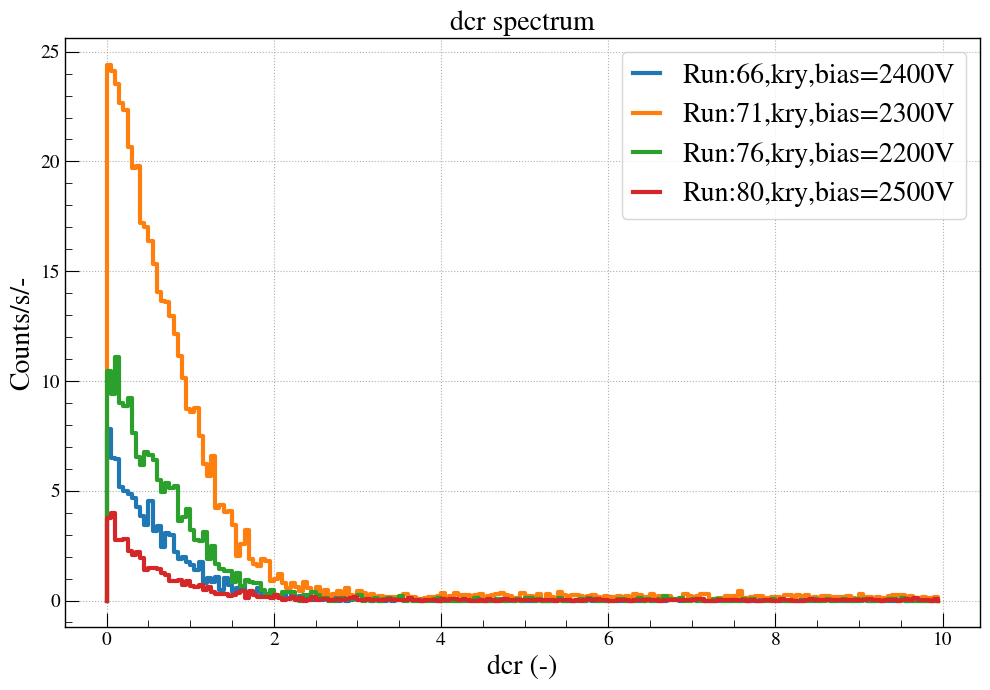

In [ ]:
# dcr spectrums
for run, bv in zip(runs, bias_voltages):
    runtime, t, d = kutils.load_dsp(run=run, params=[['dcr']], verbose=False)
    binsize = 0.05
    range= (0, 10)
    #print(d.pulse_rise_time.describe())
    h, b, v = pgh.get_hist(d['dcr'], bins=np.arange(*range, binsize), range=range)
    h = h/runtime/binsize
    pgh.plot_hist(h, b, label='Run:'+str(run)+','+t+',bias='+str(bv)+'V')


plt.xlabel('dcr (-)')
plt.ylabel('Counts/s/-')
plt.title('dcr spectrum')
plt.legend()

In [ ]:
f = h5py.File('/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run80_cyc3413_dsp.lh5', 'r')
g = f['ORSIS3302DecoderForEnergy']['dsp']
g.keys()

<KeysViewHDF5 ['A_avg', 'A_gaus', 'bl', 'bl_intercept', 'bl_sig', 'bl_slope', 'channel', 'dcr', 'energy', 'ftp', 'stp_02', 'stp_05', 'stp_10', 'stp_20', 'stp_max', 'stp_min', 'swf_max', 'swf_min', 'timestamp', 'tmax', 'tp_0', 'tp_02', 'tp_05', 'tp_10', 'tp_20', 'tp_50', 'tp_90', 'tp_96', 'tp_max', 'tp_min', 'trapEftp', 'trapEmax', 'trapTmax', 'triE', 'wf_max', 'wf_min']>

In [ ]:
# A spectrum
for run, bv in zip(runs, bias_voltages):
    runtime, t, d = kutils.load_dsp(run=run, params=[['A']], verbose=False)
    d['pulse_rise_time'] = d['stp_20']-d['tp_0'] 
    binsize = 10
    range= (0, 3000)
    #print(d.pulse_rise_time.describe())
    h, b, v = pgh.get_hist(d[d.pulse_rise_time>0]['pulse_rise_time'], bins=np.arange(*range, binsize), range=range)
    h = h/runtime/binsize
    pgh.plot_hist(h, b, label='Run:'+str(run)+','+t+',bias='+str(bv)+'V')


plt.xlabel('Rise time (us)')
plt.ylabel('Counts/s/ns')
plt.title('Pulse rise time (stp20-tp0)')
plt.legend()

RuntimeError: 'ORSIS3302DecoderForEnergy/dsp/A' not in file /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run66_cyc3230_dsp.lh5

In [ ]:
legend_ana_dir = '/global/cfs/cdirs/legend/software/KrSTC/data/analysis'
legend_data_dir = '/global/cfs/cdirs/legend/software/KrSTC/data'



import os, h5py, json, copy
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('/global/homes/f/fnafis/utils_nf/nfuad.mpl')

from pygama.flow import DataGroup
from pygama.lgdo.lh5_store import load_nda, LH5Store
import pygama.math.histogram as pgh
from pygama.lgdo import ls, load_dfs
from pygama.dsp import build_dsp
from pygama.vis import WaveformBrowser

import pint
ureg = pint.UnitRegistry()

import pygama.lgdo.lh5_store as lh5
import pygama.math.histogram as pgh



# bias voltage notes
https://maxwell.npl.washington.edu/elog/Majorana/UWMJLab/632

Kr runs:
Apr 21 - 2500V : 3057-3098
Apr 22 - 2500V : 3099 [CJ said: will be interesting to see if this cycle has lower Kr rate than others]



In [ ]:
kr_runs = [
    ['2500V, Apr21, Kr', 3057, 3098],
    ['2400V, Apr24, Kr', 3230, 3249],
    ['2300V, Apr25, Kr', 3294, 3314],
    ['2200V, Apr26, Kr', 3363, 3376],
    ['2500V, Apr27, Kr', 3413, 3417]]

krtscDB = DataGroup('/global/cfs/cdirs/legend/software/KrSTC/data/krstc.json', load=True)
runDB = krtscDB.runDB
lh5_dir = krtscDB.lh5_dir
dsp_list = lh5_dir + krtscDB.fileDB['dsp_path'] + '/' + krtscDB.fileDB['dsp_file']
dsp_list.iloc[-1]

'/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run84_cyc3609_dsp.lh5'

In [ ]:
beginning_cycle = 2019
hit_list = dsp_list[2769-beginning_cycle:2787-beginning_cycle]
runtime = krtscDB.fileDB['runtime'][2769-beginning_cycle:2787-beginning_cycle].sum() #mins
df_hit = lh5.load_dfs(hit_list, ['energy','trapEmax'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit

,energy,trapEmax
0,43975,46.960480
1,348106,371.104126
2,796246,849.504028
3,360361,384.469025
4,23245,25.186420
...,...,...
2194853,4269206,4550.416992
2194854,753086,804.336060
2194855,598279,638.326294
2194856,545172,581.884705


Text(0, 0.5, 'Counts/second/keV')

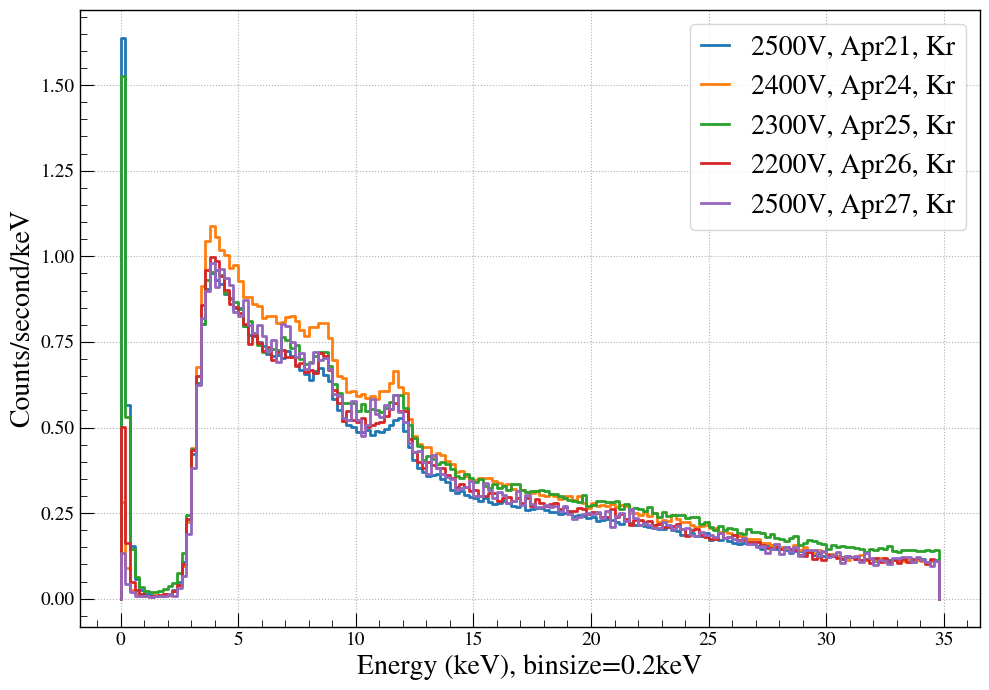

In [ ]:
beginning_cycle = 2019
e_lit = [238, 1460]
e_uncal = [5.515e5, 3.3745e6]
poly_coeffs = np.polyfit(e_uncal, e_lit, 1) 
poly_func = np.poly1d(poly_coeffs)

binsize = 0.2 #keV
ecal_range = [0, 35] #keV
for kr_run in kr_runs:
    hit_list = dsp_list[kr_run[1]-beginning_cycle:kr_run[2]-beginning_cycle]
    runtime = krtscDB.fileDB['runtime'][kr_run[1]-beginning_cycle:kr_run[2]-beginning_cycle].sum() #mins
    df_hit = lh5.load_dfs(hit_list, ['energy'] ,'ORSIS3302DecoderForEnergy/dsp')
    df_hit['energy_cal'] = poly_func(df_hit['energy'])
    #get hist
    hist, bins, var = pgh.get_hist(df_hit['energy_cal'], bins=np.arange(*ecal_range, binsize), range=ecal_range)
    # normalize hist to counts/seconds
    hist = hist/(runtime*60)/binsize #counts/seconds/keV
    pgh.plot_hist(hist, bins, lw=2, label=kr_run[0])

plt.legend()
plt.xlabel('Energy (keV), binsize='+ str(binsize)+ 'keV')
plt.ylabel('Counts/second/keV')
        

# bl vs bl_intercept for regular vs weird cycles fo run 71

In [3]:
df, rt = kutils.load_dsp(run=71, params=[['trapEmax','bl', 'bl_intercept']], verbose=False)
df

,trapEmax,bl,bl_intercept,trapEmax_cal_keV,run,cycle,runtime_s
0,332.386353,33823.871094,33824.050781,143.390518,71,3294,1500.017705
1,459.943207,33816.230469,33815.816406,198.367523,71,3294,1500.017705
2,935.228638,33812.503906,33813.437500,403.215515,71,3294,1500.017705
3,354.831757,33900.714844,33901.027344,153.064484,71,3294,1500.017705
4,687.276917,33800.003906,33800.386719,296.348328,71,3294,1500.017705
...,...,...,...,...,...,...,...
69861,2129.253906,33860.378906,33860.253906,917.840454,71,3314,870.070975
69862,265.995087,33782.523438,33782.242188,114.775887,71,3314,870.070975
69863,617.718750,33790.113281,33790.339844,266.368774,71,3314,870.070975
69864,19.058516,33804.855469,33804.667969,8.346220,71,3314,870.070975


binsize: 0.445703125
binsize: 0.446015625
binsize: 2.765632812499971
binsize: 2.7724609375


Text(0.5, 0, 'bl')

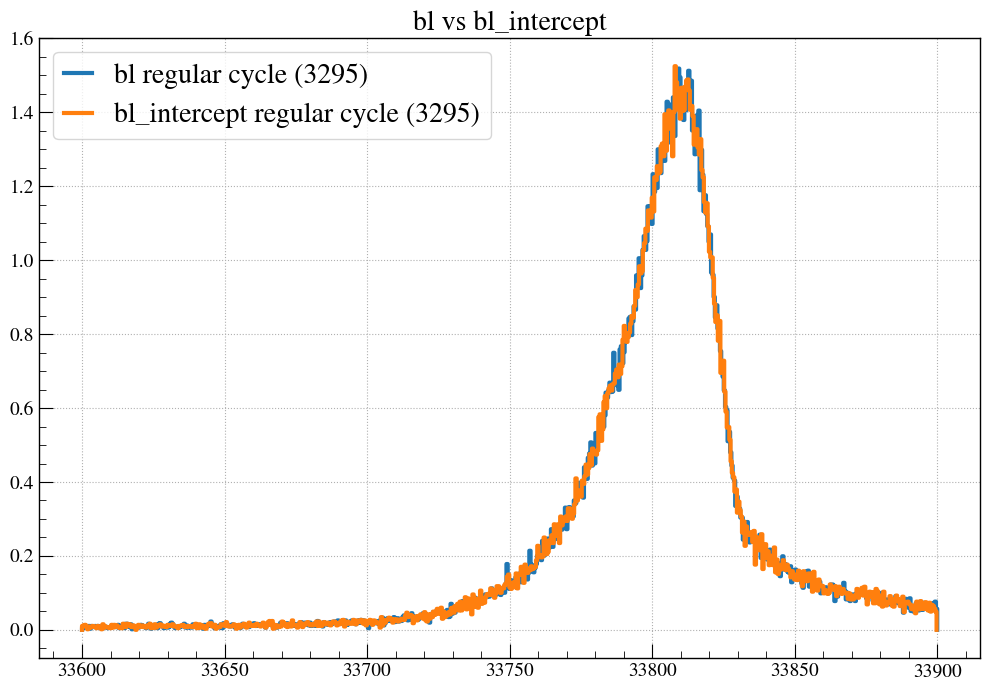

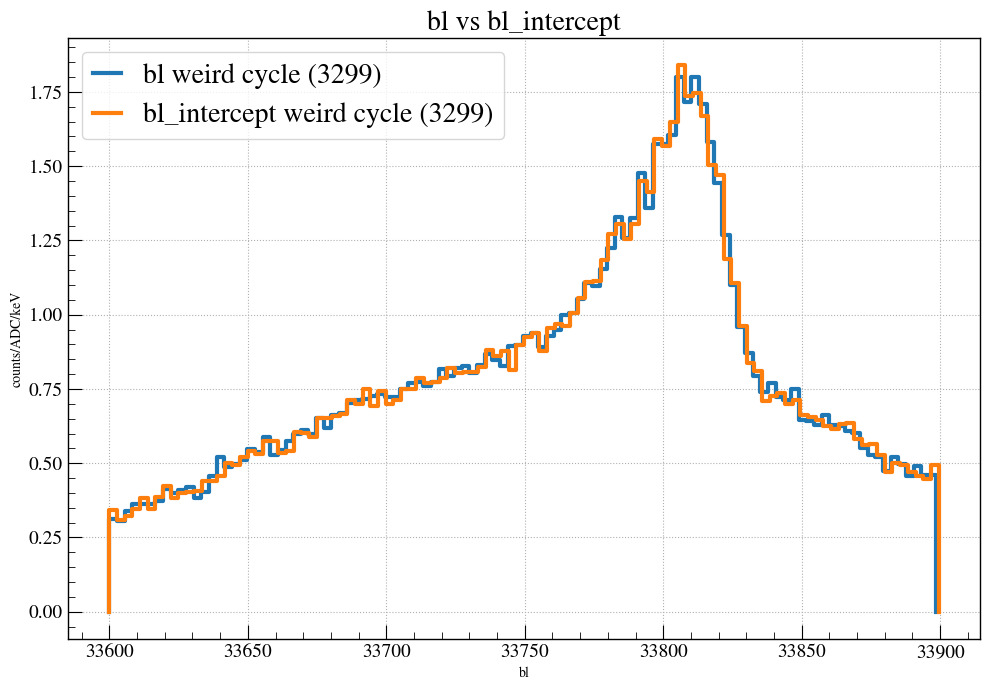

In [17]:
df_regular = df[df.cycle==3295]
df_weird = df[df.cycle==3299]

plt.figure()
range = (33600, 33900)
kutils.get_1D_hist(df_regular.bl, df_regular.runtime_s, label='bl regular cycle (3295)', range=range)
kutils.get_1D_hist(df_regular.bl_intercept, df_regular.runtime_s, label='bl_intercept regular cycle (3295)', range=range)
plt.title('bl vs bl_intercept')

plt.figure()
kutils.get_1D_hist(df_weird.bl, df_weird.runtime_s, label='bl weird cycle (3299)', range=range)
kutils.get_1D_hist(df_weird.bl_intercept, df_weird.runtime_s, label='bl_intercept weird cycle (3299)', range=range)
plt.title('bl vs bl_intercept')

plt.ylabel('counts/ADC/keV')
plt.xlabel('bl')

binsize: 0.445703125
binsize: 2.765632812499971
binsize: 0.446015625
binsize: 2.7724609375


Text(0.5, 0, 'bl')

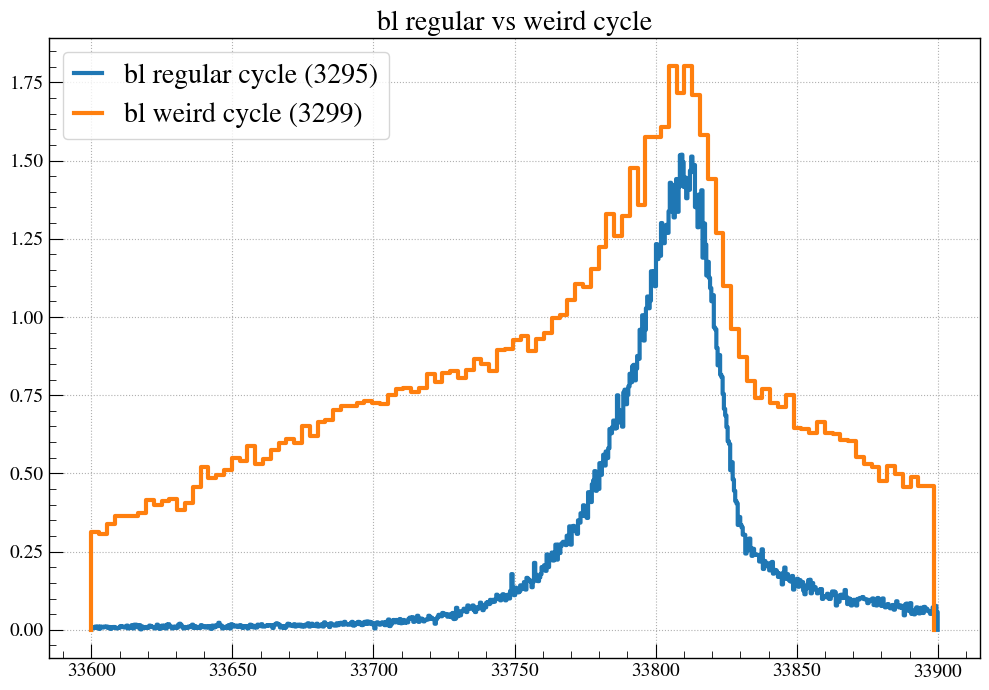

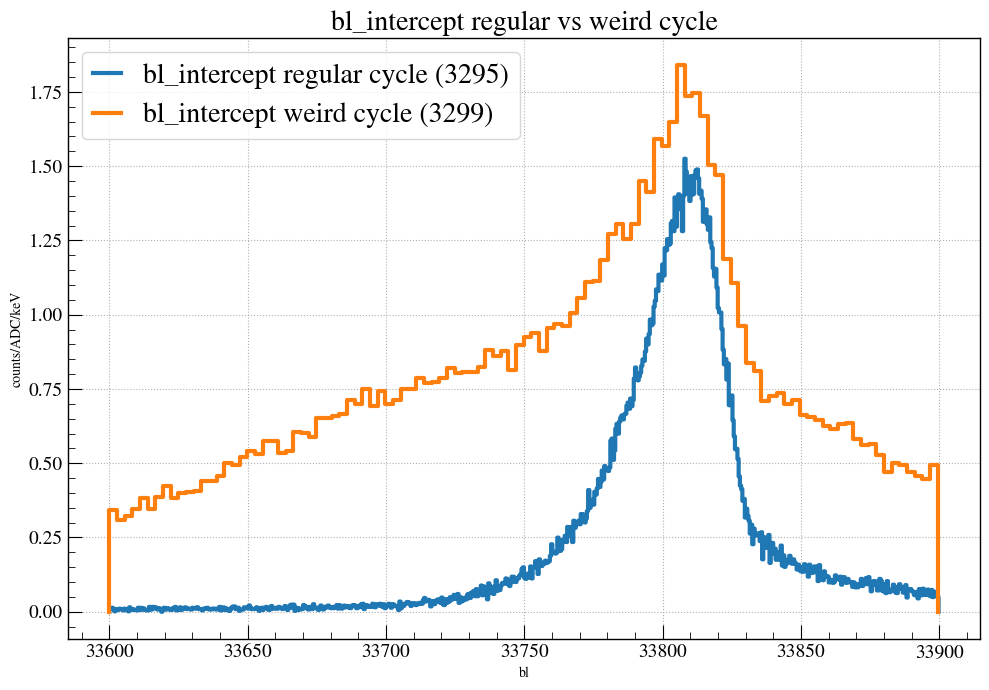

In [18]:
df_regular = df[df.cycle==3295]
df_weird = df[df.cycle==3299]

plt.figure()
range = (33600, 33900)
kutils.get_1D_hist(df_regular.bl, df_regular.runtime_s, label='bl regular cycle (3295)', range=range)
kutils.get_1D_hist(df_weird.bl, df_weird.runtime_s, label='bl weird cycle (3299)', range=range)

plt.title('bl regular vs weird cycle')

plt.figure()
kutils.get_1D_hist(df_regular.bl_intercept, df_regular.runtime_s, label='bl_intercept regular cycle (3295)', range=range)
kutils.get_1D_hist(df_weird.bl_intercept, df_weird.runtime_s, label='bl_intercept weird cycle (3299)', range=range)
plt.title('bl_intercept regular vs weird cycle')

plt.ylabel('counts/ADC/keV')
plt.xlabel('bl')